# 04 Machine learning 02
# Pretrained model "mobilenet" with Random-Forest Classifier

# Procedure in general
1. Define model name and input data set path for images
2. Define Mobilenet as pretrained model to load from
3. Load data defined by step 1, and preprocess it with pretrained model; results in => new features per data set
4. Apply Random Forest classifier on featured datas from step 3 with 80 estimators
5. Doing a short loop to check quickly the change of the accuracy (before I will use hyperparameter tuning).  
  5.1 Display wrong predictions  
  5.2 Display confusion matrix  
  5.3 Display class distribution  




In [1]:
# Step 1
import JassSummarizer as js
from enum import Enum
from PIL import Image
import matplotlib.pyplot as plt 
from IPython.core.display import display, HTML
import json
from tqdm import tqdm
import numpy as np
import pandas as pd
import random
import time
import re
import cv2
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, InputLayer, Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
import tensorflow.keras as keras
import tensorflow as tf


cnnModels=Enum("cnnModels","RMF224PT",start=0)                                                     # name model
trainedDataPaths=["ii","iii","iv"]                                                                 # available dataPaths
trainedDataPaths=["ii"]                                                                            # used Datapaths
img_graph = tf.Graph()                                                                             # Create graph
doFilePercent=99
results= pd.DataFrame([])

In [2]:
# Step 2
img_graph = tf.Graph()                                                                             # Create graph
with img_graph.as_default():
    module_url = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2'         # library url
    feature_extractor = hub.Module(module_url)                                                     # Download module
    input_imgs = tf.placeholder(dtype=tf.float32, shape=[None, 224, 224, 3])                       # Create input placeholder
    imgs_features = feature_extractor(input_imgs)                                                  # A node with the features
    init_op = tf.group([tf.global_variables_initializer(), tf.tables_initializer()])               # Collect initializers
img_graph.finalize()                                                                               # Good practice: make the graph "read-only"

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [3]:
# Step 3
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"                                                              # disable GPU

# LOOP A
for cnnModel in cnnModels:                                                                             # leave loop even if just One model is defined
    mode=int(re.findall(r'\d+',cnnModel.name)[0])                                                      # get image dimension
    subMode=cnnModel.name[-2:]                                                                         # get subMode name
    size = (mode, mode)                                                                                # define size
    mlDimension = (mode,mode,3)                                                                        # define input shape
    fileListMaster= []                                                                                 # define fileListMaster
    pathMaster="_"                                                                                     # define pathMaster
    
    # LOOP B    
    for dataPath in trainedDataPaths:                                                                  # loop if more then one dataPath is used
        path = os.path.join(r".\images\02_data_preparation", "train_datascan_"+dataPath)               # generate path
        pathMaster += dataPath                                                                         # store path for later identifications
        fileList = [os.path.join(dp, f) for dp, dn, filenames in os.walk(path) for f in filenames if os.path.splitext(f)[1] == ".jpg"]

        if (doFilePercent !=100):                                                                      # shuffle and slice percentage
            a=fileList                                                                                 # temporary variable
            random.shuffle(a)                                                                          # shuffle entries
            percent=int(len(fileList)/100*doFilePercent)                                               # slice
            fileList=a[0:percent]                                                                      # reassign
            
        fileListMaster=fileListMaster+fileList                                                         # used on multiple dataPath
    path=pathMaster                                                                                    # reassign path selections
    fileList=fileListMaster                                                                            # reassign collected samples
    display(HTML(f"<h3>Analyzing Model {cnnModel.name}, by {mode}x{mode} with {len(fileList)} images</h3>"))   # inform about selected trainings data
    time.sleep(0.3)                                                                                    # short sleeper because of tqm output 

    X=[] ;y=[]                                                                                         # initialize
    modelData = {}                                                                                     # initialize

    with tqdm(total=len(fileList)) as pbar:                                                            # progess bar
        for fName in fileList:                                                                         # file/image iterator
            nameOnly=fName.split("\\")[-1]                                                             # extract filename
            cardId=nameOnly[0:2]                                                                       # extract cardId
            myImage=cv2.imread(fName,cv2.IMREAD_COLOR)                                                 # read imageDate
            data=js.analyzeScan(myImage,0.4)                                                           # preprocess image data
            frameOrg,mask,img_rect,res,crop_img, d = data                                              # separate results
            resized = cv2.resize(crop_img, size, interpolation = cv2.INTER_AREA)                       # resize to input shape
            r2=cv2.cvtColor(resized,cv2.COLOR_BGR2RGB)                                                 # BGR 2 RGB color channel switch
            r3=js.backgroundDiffuser3(r2)                                                              # background optimization
            X.append(r3/255)                                                                           # normalize to fractions
            y.append([cardId.upper()])                                                                 # save cardId for later y_train or y_test
            pbar.update(1)                                                                             # update progress bar

    # split data into train and test
    X_train_raw, X_test_raw, y_train_raw, y_test_raw ,y_train_file, y_test_file = train_test_split(
        np.array(X),np.array(y,dtype="O"), np.array(fileList), test_size=0.2, random_state=42, stratify=y)
    
    for dataSet in ["train","test"]:
        img_batch=eval("X_"+dataSet+"_raw")
        initialization_op = tf.global_variables_initializer()                                          # Init
        sess = tf.Session(graph=img_graph)                                                             # Create a session
        sess.run(init_op)                                                                              # Initialize it
        features = sess.run(imgs_features, feed_dict={input_imgs: img_batch})                          # Extract features
        key=f"X_{dataSet.replace('_raw','')}_features"                                                 # dictionary keyName set
        modelData[key]=features                                                                        # put array into dict
        key=f"y_{dataSet.replace('_raw','')}_targets"                                                  # set keyName for y values
        modelData[key]=eval("y_"+dataSet+"_raw")                                                       # put array into dict
        print(f"dataPath: {path}, dataset: {dataSet:6} with {features.shape[0]:6} entries, features: {features.shape[1]} ")                                                   
    np.savez("pretrainedFeatureData", dict=modelData)                                                  # save feature and targets as pickle file                                                      

    
    
    if 1==2:
        modelName=f"{cnnModel.name}_{path.split('_')[-1]}_{doFilePercent}"
        modelFile=os.path.join(r".\model_save",modelName)
        model_json = model.to_json()
        with open(modelFile+".json", "w") as json_file:
            json_file.write(model_json)
        model.save_weights(modelFile+".h5")
  

100%|██████████████████████████████████████████████████████████████████████████████| 1142/1142 [04:30<00:00,  4.23it/s]


dataPath: _ii, dataset: train  with    913 entries, features: 1280 
dataPath: _ii, dataset: test   with    229 entries, features: 1280 


In [4]:
# Step 4
from sklearn.ensemble import RandomForestClassifier

X_train=modelData["X_train_features"]
X_test=modelData["X_test_features"]
y_train=modelData["y_train_targets"].reshape(-1)
y_test=modelData["y_test_targets"].reshape(-1)

model = RandomForestClassifier(n_estimators=80)
model.fit(X_train,y_train)
if 1==1:
    for j, modelName in enumerate(["train","test"]):    
        scoreRF=model.score(eval(f"X_{modelName}"), eval(f"y_{modelName}"))
        print("Accuracy {0:7} set is {1:7.3f}%".format(modelName,scoreRF*100)) 
    display(HTML("<h3>Random Forest score {} with 80 estimators(Trees)</h3>".format(scoreRF)))

Accuracy train   set is 100.000%
Accuracy test    set is  97.817%


In [5]:
# Step 5
from sklearn.ensemble import RandomForestClassifier

for j in np.arange(10,200,10):
    model = RandomForestClassifier(n_estimators=j, max_depth=None, random_state=0)
    model.fit(X_train,y_train)
    score = model.score(X_test,y_test)
    print("Random Forest score {0:7.2f} with {1:} estimators(Trees)".format(score*100,j))

Random Forest score   91.27 with 10 estimators(Trees)
Random Forest score   94.76 with 20 estimators(Trees)
Random Forest score   96.51 with 30 estimators(Trees)
Random Forest score   97.82 with 40 estimators(Trees)
Random Forest score   97.38 with 50 estimators(Trees)
Random Forest score   97.82 with 60 estimators(Trees)
Random Forest score   97.82 with 70 estimators(Trees)
Random Forest score   97.82 with 80 estimators(Trees)
Random Forest score   98.25 with 90 estimators(Trees)
Random Forest score   97.82 with 100 estimators(Trees)
Random Forest score   98.69 with 110 estimators(Trees)
Random Forest score   98.69 with 120 estimators(Trees)
Random Forest score   98.25 with 130 estimators(Trees)
Random Forest score   97.38 with 140 estimators(Trees)
Random Forest score   97.38 with 150 estimators(Trees)
Random Forest score   98.25 with 160 estimators(Trees)
Random Forest score   97.82 with 170 estimators(Trees)
Random Forest score   97.38 with 180 estimators(Trees)
Random Forest score

In [6]:
# Step 5.1
y_predicted=model.predict(X_test)
for j, predict in enumerate(y_predicted):
    if predict != y_test[j]:
        print(predict,y_test[j])

A3 A1
A4 A5
A3 A2
A2 A0
D3 D1


In [7]:
# Step 5.2 
import sklearn.metrics

pd.options.display.max_columns = None                                                                  # disable column hiding
display(HTML("<h1>Confusion Matrix</h1>"))                                                             # print title

y_true = y_test                                                                                        # get data
y_pred = y_predicted                                                                                   # get data
newColumn=[]                                                                                           # initialize

r = sklearn.metrics.confusion_matrix(y_true, y_pred)                                                   # get confusion matrix
cmDf=pd.DataFrame(r.astype("O"))                                                                       # as string type
cmDf=cmDf.replace(0,".")                                                                               # for better visualizing replace 0 with .
for card in js.JassCN2._member_names_:                                                                 # make nice column names
    newColumn=newColumn+[card]                                                                         # next Card Id to column
cmDf.columns=newColumn                                                                                 # apply new column names
cmDf                                                                                                   # display dataframe and set column header
cmDf.style.set_table_styles(
    [dict(selector="th",props=[('max-width', '10px')]),
        dict(selector="th.col_heading",
                 props=[("writing-mode", "vertical-rl"), 
                        ('transform', 'rotateZ(-90deg)'),
                        ])])

,A0,A1,A2,A3,A4,A5,A6,A7,A8,B0,B1,B2,B3,B4,B5,B6,B7,B8,C0,C1,C2,C3,C4,C5,C6,C7,C8,D0,D1,D2,D3,D4,D5,D6,D7,D8
0,4,.,1,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
1,.,3,.,1,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
2,.,.,3,1,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
3,.,.,.,6,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
4,.,.,.,.,7,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
5,.,.,.,.,1,6,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
6,.,.,.,.,.,.,7,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
7,.,.,.,.,.,.,.,6,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,.,5,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
9,.,.,.,.,.,.,.,.,.,5,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.


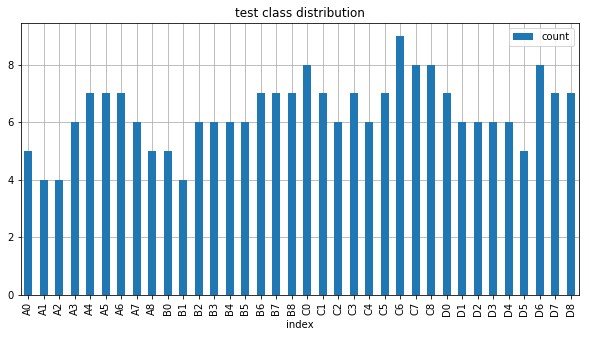

In [8]:
# Step 5.3
pd.DataFrame(pd.Series(y_test).value_counts(),columns=["count"]).reset_index().sort_values("index").set_index("index").plot(kind="bar",
        grid=True,figsize=(10,5),title="test class distribution",zorder=10)


In [9]:
import sklearn.externals.joblib as joblib

modelName=f"{cnnModel.name}_{path.split('_')[-1]}_{doFilePercent}"
modelFile=os.path.join(r".\model_save",modelName)
joblib.dump(model, modelFile+".joblib")

['.\\model_save\\RMF224PT_ii_99.joblib']